## 不同角宽度

### 图片三

##### 1.定义傅里叶功率谱和小波功率谱这两个函数

In [1]:
# 傅立叶功率谱 

import numpy 
from scipy.stats.distributions import chi2
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot
import math
'''
功率谱分析
输入：
x：需要分析的时间序列(原始序列，未标准化或距平处理)
m：最大滞后相关长度，m取值范围最好在(n/10)~(n/3)之间，n为样本数，可以多次调整m获得最佳效果，通常取m=n/3
alpha1：红噪音检验信度
alpha2：白噪音检验信度
输出：
l：功率谱图的X坐标，对应的周期为2m/l，使用时自己调整tick labels
Sl：功率谱估计值
Sr：红噪音
Sw：白噪音
r1：落后一个时刻的自相关函数，用于查看使用哪种噪音检验
'''
def specx_anal(x,m,alpha1,alpha2):
    n = x.shape[0]
    x = (x - numpy.mean(x))/numpy.std(x)
    r1 = numpy.zeros((n-6))
    r2 = numpy.zeros((n-7))
    for i in numpy.arange(0,n-6):
        r1[i]=numpy.sum(x[:n-i]*x[i:])/x[:n-i].shape[0]
    for i in numpy.arange(1,n-6):
        r2[i-1]=numpy.sum(x[:n-i]*x[i:])/x[:n-i].shape[0]
    r2 = r2[::-1]
    r = numpy.hstack((r2,r1))
    l = numpy.arange(0,m+1,1)
    tao = numpy.arange(1,m,1)
    Sl  = numpy.zeros((m+1))
    Tl  = numpy.zeros((m+1))
    S0l = numpy.zeros((m+1))
    a = numpy.array((r.shape[0]+1)/2).astype('int32')
    r = r[a-1:a+m]
    a=r[1:-1]*(1+numpy.cos(numpy.pi*tao/m))
    for i in numpy.arange(2,m+1,1):
        Sl[i-1]=(r[0]+numpy.sum(a*numpy.cos(l[i-1]*numpy.pi*tao/m)))/m 
    Sl[0]=(r[0]+numpy.sum(a*numpy.cos(l[0]*numpy.pi*tao/m)))/(2*m)
    Sl[-1]=(r[0]+numpy.sum(a*numpy.cos(l[-1]*numpy.pi*tao/m)))/(2*m)
    for i in range(l.shape[0]):
        Tl[i]=2*m/l[i]
    f=(2*n-m/2)/m
    S=numpy.mean(Sl)
    for i in range(l.shape[0]):
        S0l[i]=S*(1-r[1]*r[1])/(1+r[1]*r[1]-2*r[1]*numpy.cos(l[i]*numpy.pi/m))
    x2r = chi2.ppf(1-alpha1,df = f)
    Sr=S0l*x2r/f
    x2w = chi2.ppf(1-alpha2,df = f)
    Sw=S*x2w/f;
    r1=r[1]
    period=2*m/l
    return period,Sl,Sr,Sw,r1

In [2]:
# 定义累计分布函数
def ecdf(a):
    x, counts = numpy.unique(a, return_counts=True)  # numpy.unique：用于去除数组中重复元素，并从小到大排序。
    cusum = numpy.cumsum(counts)                     # numpy.cumsum ：计算轴向元素累加和，返回由中间结果组成的数组           
    return x, cusum / cusum[-1]

In [4]:
def Fourier_Power_Spectrum(dat,t,sign):

    
    # 创建时间序列和数据准备
    # dat = numpy.load('all_y_numpy.npy')
    # t = numpy.load('all_x_numpy.npy')
    N = len(dat)
    
    
    # 傅立叶谱的函数调用
    # 打乱的原始数据
    p0 = 0.05    #                                                                                                                                   
    x = dat.copy()
    numpy.random.shuffle(x)
    # print('x=',x)
    l,Sl,Sr,Sw,r1 = specx_anal(x,x.shape[0]//3,0.1,0.1)
    # 不变的原始数据
    x1 = dat.copy()
#     print('x1=',x1)
    l1,Sl1,Sr1,Sw1,r11 = specx_anal(x1,x1.shape[0]//3,0.1,0.1)
    
    
    # 累积分布函数的调用
    # Sl 已打乱原始数据的累积分布函数
    data_sorted, p = ecdf(Sl)
    # 计算随机数据的拟合直线斜率和
    z1 = numpy.polyfit(data_sorted[:-1], numpy.log(1-p)[:-1], 1)  #一次多项式拟合，相当于线性拟合
    pline = numpy.poly1d(z1)
    # print(round(z1[0],4),round(z1[1],4)) 
    print(pline)
    # 通过已打乱原始数据的累积分布函数求解方差和标准差
    Sigma_square=abs(1/2/(round(z1[0],4)))
    print('Sigma_square=',Sigma_square)
    Sigma=math.sqrt(Sigma_square)
    print('Sigma=',Sigma)
    # Sl1 原始数据的累积分布函数
    data1_sorted, p1 = ecdf(Sl1)
    # 95%显著性水平
    power_95 = (-(numpy.log(1-(1-p0)**(1/(N/2)))))*Sigma_square
    print('power_95=',power_95)
    pro = numpy.log(1-p)
    pro1 = numpy.log(1-p1)

    return l1,Sl1,power_95,data_sorted[:-1],pro[:-1],data1_sorted[:-1],pro1[:-1],Sigma_square,sign
    
    
    
    


In [24]:
# 小波功率谱

"""
In this example we will load the NINO3 sea surface temperature anomaly dataset
between 1871 and 1996. This and other sample data files are kindly provided by
C. Torrence and G. Compo at
<http://paos.colorado.edu/research/wavelets/software.html>.
Tutorial
<https://pycwt.readthedocs.io/en/latest/tutorial.html#f2>

INPUTS ： dat,t,sign
dat = numpy.load('all_y_numpy.npy')
t = numpy.load('all_x_numpy.npy')
sign = "ALL cme"

OUTPUTS ： 原始数据图，小波功率图，全局功率图

"""
# 导入相应的包
from __future__ import division
import numpy
import pandas
from scipy.signal import savgol_filter
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import pycwt as wavelet
from pycwt.helpers import find
from mpl_toolkits.axes_grid1 import make_axes_locatable

def Wavelet_Power_Spectrum(dat,t,sign):

    # 小波功率谱的函数定义
    
    
    # 创建时间序列和数据准备
    # dat = numpy.load('all_y_numpy.npy')
    # t = numpy.load('all_x_numpy.npy')
    N = len(dat)
    t0 = []
    t0_year = []

    for i in range(len(t)):
        new_t_t = pandas.Series(t[i])
        new_t = pandas.to_datetime(new_t_t, format='%Y-%m-%d')
        year = new_t.dt.year
        month = (new_t.dt.month)/12
        day = (new_t.dt.day)/365
        add_t = float(('%.4f' % (year+month+day)))
        t0.append(add_t)
        t0_year.append(int(year))

    t_year = t0_year
    t0array = numpy.array(t0)
    DYMT = t0array - t_year    
    dt = 1.0  # In day


    # 没有去趋势
    p = numpy.polyfit(DYMT,dat,1)
    dat_notrend = dat - numpy.polyval(p,DYMT)
    std = dat_notrend.std()  # Standard deviation
    var = std ** 2  # Variance
    dat_norm = dat_notrend / std  # Normalized dataset


    # 小波参数设置
    mother = wavelet.Morlet(6)
    s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
    dj = 1 / 12  # Twelve sub-octaves per octaves  # 不一样
    # J = 7 / dj  # Seven powers of two with dj sub-octaves
    J = numpy.fix((numpy.log(N * dt / s0) / numpy.log(2)) / dj) 
    alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
    print('alpha=',alpha)

    # 下面的程序使用上面定义的参数进行小波变换
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                        mother)

    # 我们计算归一化的小波，以及每个小波尺度的傅里叶等效周期。
    power = (numpy.abs(wave)) ** 2
    period = 1 / freqs

    # 我们可以在这一点上停下来，绘制我们的结果。然而，我们也对功率谱的显著性测试感兴趣。当功率/sig95的
    # 比率>1时，功率是显著的。
    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                            significance_level=0.95,
                                            wavelet=mother)
    sig95 = numpy.ones([1, N]) * signif[:, None]
    sig95 = power / sig95
    
    
    # 然后，我们计算全局小波谱并确定其显著性水平。
    glbl_power = power.mean(axis=1)
    dof = N - scales  # Correction for padding at edges
    glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                            significance_level=0.95, dof=dof,
                                            wavelet=mother)
    
#     # 傅立叶谱的函数调用
#     # 打乱的原始数据
#     p0 = 0.05    #                                                                                                                                   
#     x = dat.copy()
#     numpy.random.shuffle(x)
#     # print('x=',x)
#     l,Sl,Sr,Sw,r1 = specx_anal(x,x.shape[0]//3,0.1,0.1)
#     # 不变的原始数据
#     x1 = dat.copy()
# #     print('x1=',x1)
#     l1,Sl1,Sr1,Sw1,r11 = specx_anal(x1,x1.shape[0]//3,0.1,0.1)
    
    
#     # 累积分布函数的调用
#     # Sl 已打乱原始数据的累积分布函数
#     data_sorted, p = ecdf(Sl)
#     # 计算随机数据的拟合直线斜率和
#     z1 = numpy.polyfit(data_sorted[:-1], numpy.log(1-p)[:-1], 1)  #一次多项式拟合，相当于线性拟合
#     p1 = numpy.poly1d(z1)
#     # print(round(z1[0],4),round(z1[1],4)) 
#     print(p1)
#     # 通过已打乱原始数据的累积分布函数求解方差和标准差
#     Sigma_square=abs(1/2/(round(z1[0],4)))
#     print('Sigma_square=',Sigma_square)
#     Sigma=math.sqrt(Sigma_square)
#     print('Sigma=',Sigma)
#     # Sl1 原始数据的累积分布函数
#     data1_sorted, p1 = ecdf(Sl1)
    
    return period,glbl_signif,var,glbl_power,t0array,power,sig95,coi,sign




##### 2.调用傅里叶功率谱和小波功率谱这两个函数，绘制相应的功率谱图片

In [11]:
# 绘制图片(傅立叶功率谱、累积分布图、全局小波图、局部小波图)

figprops = dict(figsize=(20,22), dpi=300)
fig = pyplot.figure(**figprops)   
gs = GridSpec(10,8, wspace=1.2, hspace=1.2) 
# pyplot.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95,
#                             wspace=0, hspace=0)
fig.suptitle('Whole Time (January 1996 to August 2021)', y=0.92, fontsize=16)


# all
# 傅立叶功率图
l1,Sl1,power_95,data_sorted,pro,data1_sorted,pro1,Sigma_square,sign = Fourier_Power_Spectrum(dat = numpy.load('all_y_numpy.npy') ,t = numpy.load('all_x_numpy.npy'),sign = "All")
ax01 = pyplot.subplot(gs[0:2, 0:2])
ax01.plot(l1,numpy.log(Sl1),'black',label='Fourier spectrum')
pyplot.axhline(y=numpy.log(power_95), c="r", ls="--",label='95% confidence level')
# pyplot.text(36,0.0075,'1.2 Mo')
# pyplot.text(89,0.006,'3 Mo')
# ax01.annotate('1.2 Mo', xy=(36, -6.3), xytext=(90, -2.1), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax01.annotate('2.9 Mo', xy=(89, -6.5), xytext=(690, -2.7), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax01.annotate('4.9 Mo', xy=(148, -6.4), xytext=(870, -4), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax01.annotate('6 Mo', xy=(182, -5.5), xytext=(2550, -3.7), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax01.annotate('9 Mo', xy=(275, -6.5), xytext=(1500, -6.5), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax01.annotate('1 Yr', xy=(367, -6), xytext=(2700, -6.1), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax01.annotate('1.2 Yr', xy=(445, -5.6), xytext=(2000, -5.6), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax01.annotate('2.4 Yr', xy=(894, -5), xytext=(2100, -5), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
ax01.set_xlabel('Period (day)',fontsize=14)
ax01.set_ylabel('Log power',fontsize=14)
#     pyplot.ylim(0,0.005)
pyplot.xlim(16,)
# pyplot.ylim(0,0.16)
pyplot.legend(loc='lower right', fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)

# 累积分布图
ax02= pyplot.subplot(gs[0:2,2:4])
ax02.plot(data1_sorted,pro1,color='black',label='Original')
ax02.plot(data_sorted,pro,color='red',label='Randomized')
# 标记标准差
# print('3sigma=',9*Sigma_square)
pyplot.text(power_95-0.00009,-1,'95%')
pyplot.text(power_95,-1.5,"|")
    
pyplot.text(8*Sigma_square,-2.5,"3"r"$\sigma$")
pyplot.text(9*Sigma_square,-3,"|")

pyplot.text(15*Sigma_square,-2.5,"4"r"$\sigma$")
pyplot.text(16*Sigma_square,-3,"|")

pyplot.text(24*Sigma_square,-2.5,"5"r"$\sigma$")
pyplot.text(25*Sigma_square,-3,"|")

pyplot.text(35*Sigma_square,-2.5,"6"r"$\sigma$")
pyplot.text(36*Sigma_square,-3,"|")
ax02.set_xlabel('Log power',fontsize=14)
ax02.set_ylabel('Log cumulative distribution',fontsize=14)
pyplot.xlim(0,0.004)
# pyplot.xlim(0,0.16)
pyplot.legend(loc='upper right',fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)


# halo
# 傅立叶功率图
l1,Sl1,power_95,data_sorted,pro,data1_sorted,pro1,Sigma_square,sign = Fourier_Power_Spectrum(dat = numpy.load('halo_y_numpy.npy') ,t = numpy.load('halo_x_numpy.npy'),sign = "Halo")
ax03 = pyplot.subplot(gs[2:4,0:2])
ax03.plot(l1,numpy.log(Sl1),'black',label='Fourier spectrum')
# ax03.annotate('8.6 Yr', xy=(3122, -3.9), xytext=(3522, -4.7), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax03.annotate('3.4 Yr', xy=(1249, -6.1), xytext=(3000, -6.1), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax03.annotate('1.7 Yr', xy=(627, -6.5), xytext=(2900, -6.5), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax03.annotate('10.8 Mo', xy=(329, -6.4), xytext=(2800, -5.2), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax03.annotate('8.9 Mo', xy=(271, -6.7), xytext=(1600, -4.5), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax03.annotate('7.3 Mo', xy=(223, -6.4), xytext=(1300, -4), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax03.annotate('6 Mo', xy=(183, -6.6), xytext=(600, -4.5), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax03.annotate('1.9 Mo', xy=(58, -5.9), xytext=(120, -4), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
pyplot.axhline(y=numpy.log(power_95), c="r", ls="--",label='95% confidence level')
ax03.set_xlabel('Period (day)',fontsize=14)
ax03.set_ylabel('Log power',fontsize=14)
#     pyplot.ylim(0,0.005)
pyplot.xlim(16,)
#     pyplot.xlim(16,3500)
pyplot.legend(loc='lower right', fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)


# 累积分布图
ax04 = pyplot.subplot(gs[2:4, 2:4])
ax04.plot(data1_sorted,pro1,color='black',label='Original')
ax04.plot(data_sorted,pro,color='red',label='Randomized')
# 标记标准差
# print('3sigma=',9*Sigma_square)
pyplot.text(power_95-0.00009,-1,'95%')
pyplot.text(power_95,-1.5,"|")
    
pyplot.text(8*Sigma_square,-2.5,"3"r"$\sigma$")
pyplot.text(9*Sigma_square,-3,"|")

pyplot.text(15*Sigma_square,-2.5,"4"r"$\sigma$")
pyplot.text(16*Sigma_square,-3,"|")

pyplot.text(24*Sigma_square,-2.5,"5"r"$\sigma$")
pyplot.text(25*Sigma_square,-3,"|")

pyplot.text(35*Sigma_square,-2.5,"6"r"$\sigma$")
pyplot.text(36*Sigma_square,-3,"|")
ax04.set_xlabel('Log power',fontsize=14)
ax04.set_ylabel('Log cumulative distribution',fontsize=14)
pyplot.xlim(0,0.004)
#     pyplot.xlim(0,0.04)
pyplot.legend(loc='upper right',fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)


# wide
# 傅立叶功率图
l1,Sl1,power_95,data_sorted,pro,data1_sorted,pro1,Sigma_square,sign = Fourier_Power_Spectrum(dat = numpy.load('wide_y_numpy.npy') ,t = numpy.load('wide_x_numpy.npy'),sign = "Partial Halo")
ax05 = pyplot.subplot(gs[4:6,0:2])
ax05.plot(l1,numpy.log(Sl1),'black',label='Fourier spectrum')
# ax05.annotate('8.6 Yr', xy=(3125, -2.8), xytext=(4022, -4), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax05.annotate('3.4 Yr', xy=(1245, -6.2), xytext=(4245, -6.2), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax05.annotate('1.6 Yr', xy=(568, -6.7), xytext=(4568, -6.7), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax05.annotate('1.2 Yr', xy=(446, -6.2), xytext=(3022, -5.6), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax05.annotate('1 Yr', xy=(367, -6.5), xytext=(1222, -5.2), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax05.annotate('8.5 Mo', xy=(260, -6.4), xytext=(900, -4.7), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax05.annotate('6.4 Mo', xy=(195, -6.7), xytext=(500, -4.2), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax05.annotate('4.3 Mo', xy=(132, -6.9), xytext=(2500, -4.7), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax05.annotate('1.2 Mo', xy=(36, -6.4), xytext=(80, -3.2), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
pyplot.axhline(y=numpy.log(power_95), c="r", ls="--",label='95% confidence level')
ax05.set_xlabel('Period (day)',fontsize=14)
ax05.set_ylabel('Log power',fontsize=14)
#     pyplot.ylim(0,0.005)
pyplot.xlim(16,)
pyplot.legend(loc='lower right', fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)

# 累积分布图
ax06 = pyplot.subplot(gs[4:6,2:4])
ax06.plot(data1_sorted,pro1,color='black',label='Original')
ax06.plot(data_sorted,pro,color='red',label='Randomized')
# 标记标准差
# print('3sigma=',9*Sigma_square)
pyplot.text(power_95-0.00009,-1,'95%')
pyplot.text(power_95,-1.5,"|")
    
pyplot.text(8*Sigma_square,-2.5,"3"r"$\sigma$")
pyplot.text(9*Sigma_square,-3,"|")

pyplot.text(15*Sigma_square,-2.5,"4"r"$\sigma$")
pyplot.text(16*Sigma_square,-3,"|")

pyplot.text(24*Sigma_square,-2.5,"5"r"$\sigma$")
pyplot.text(25*Sigma_square,-3,"|")

pyplot.text(35*Sigma_square,-2.5,"6"r"$\sigma$")
pyplot.text(36*Sigma_square,-3,"|")
ax06.set_xlabel('Log power',fontsize=14)
ax06.set_ylabel('Log cumulative distribution',fontsize=14)
pyplot.xlim(0,0.004)
#     pyplot.xlim(0,0.04)
pyplot.legend(loc='upper right',fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)


# normal
# 傅立叶功率图
l1,Sl1,power_95,data_sorted,pro,data1_sorted,pro1,Sigma_square,sign = Fourier_Power_Spectrum(dat = numpy.load('normal_y_numpy.npy') ,t = numpy.load('normal_x_numpy.npy'),sign = "Normal")
ax07 = pyplot.subplot(gs[6:8,0:2])
ax07.plot(l1,numpy.log((Sl1+0.0001)),'black',label='Fourier spectrum')
# ax07.annotate('8.6 Yr', xy=(3125, -2.02), xytext=(4300, -2.6), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax07.annotate('2.4 Yr', xy=(892, -5.2), xytext=(3000, -5.2), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax07.annotate('1.2 Yr', xy=(446, -6), xytext=(2500, -6.3), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax07.annotate('1 Yr', xy=(368, -5.8), xytext=(3200, -5.8), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax07.annotate('5.9 Mo', xy=(179, -5.5), xytext=(2500, -4), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax07.annotate('4.8 Mo', xy=(145, -6.5), xytext=(900, -3), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))             
# ax07.annotate('1.2 Mo', xy=(36, -6.6), xytext=(200, -2.5), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
pyplot.axhline(y=numpy.log(power_95+0.0001), c="r", ls="--",label='95% confidence level')
ax07.set_xlabel('Period (day)',fontsize=14)
ax07.set_ylabel('Log power',fontsize=14)
#     pyplot.ylim(0,0.005)
pyplot.xlim(16,)
#     pyplot.xlim(16,3500)
pyplot.legend(loc='lower right', fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)

# 累积分布图
ax08 = pyplot.subplot(gs[6:8,2:4])
ax08.plot(data1_sorted,pro1,color='black',label='Original')
ax08.plot(data_sorted,pro,color='red',label='Randomized')
# 标记标准差
# print('3sigma=',9*Sigma_square)
pyplot.text(power_95-0.00009,-1,'95%')
pyplot.text(power_95,-1.5,"|")
    
pyplot.text(8*Sigma_square,-2.5,"3"r"$\sigma$")
pyplot.text(9*Sigma_square,-3,"|")

pyplot.text(15*Sigma_square,-2.5,"4"r"$\sigma$")
pyplot.text(16*Sigma_square,-3,"|")

pyplot.text(24*Sigma_square,-2.5,"5"r"$\sigma$")
pyplot.text(25*Sigma_square,-3,"|")

pyplot.text(35*Sigma_square,-2.5,"6"r"$\sigma$")
pyplot.text(36*Sigma_square,-3,"|")
ax08.set_xlabel('Log power',fontsize=14)
ax08.set_ylabel('Log cumulative distribution',fontsize=14)
pyplot.xlim(0,0.004)
#     pyplot.xlim(0,0.04)
pyplot.legend(loc='upper right',fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)


# narrow
# 傅立叶功率图
l1,Sl1,power_95,data_sorted,pro,data1_sorted,pro1,Sigma_square,sign = Fourier_Power_Spectrum(dat = numpy.load('narrow_y_numpy.npy') ,t = numpy.load('narrow_x_numpy.npy'),sign = "Narrow")
ax09 = pyplot.subplot(gs[8:10,0:2])
ax09.plot(l1,numpy.log(Sl1),'black',label='Fourier spectrum')
# ax09.annotate('2.4 Yr', xy=(893, -5.36), xytext=(3000, -4.7), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax09.annotate('2 Yr', xy=(694, -5.38), xytext=(2500, -5.38), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax09.annotate('1.2 Yr', xy=(446, -6.1), xytext=(2200, -6.4), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax09.annotate('11.4 Mo', xy=(347, -5.97), xytext=(2000, -5.9), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax09.annotate('7.9 Mo', xy=(240, -6.7), xytext=(1200, -4.2), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax09.annotate('6.2 Mo', xy=(189, -6.5), xytext=(830, -3.7), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax09.annotate('2.8 Mo', xy=(84, -6.7), xytext=(600, -3.3), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax09.annotate('1.4 Mo', xy=(44, -6.3), xytext=(100, -2.8), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
pyplot.axhline(y=numpy.log(power_95), c="r", ls="--",label='95% confidence level')
ax09.set_xlabel('Period (day)',fontsize=14)
ax09.set_ylabel('Log power',fontsize=14)
#     pyplot.ylim(0,0.005)
pyplot.xlim(16,)
#     pyplot.xlim(16,3500)
pyplot.legend(loc='lower right', fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)

# 累积分布图
ax10 = pyplot.subplot(gs[8:10,2:4])
ax10.plot(data1_sorted,pro1,color='black',label='Original')
ax10.plot(data_sorted,pro,color='red',label='Randomized')
# 标记标准差
# print('3sigma=',9*Sigma_square)
pyplot.text(power_95-0.00009,-1,'95%')
pyplot.text(power_95,-1.5,"|")
    
pyplot.text(8*Sigma_square,-2.5,"3"r"$\sigma$")
pyplot.text(9*Sigma_square,-3,"|")

pyplot.text(15*Sigma_square,-2.5,"4"r"$\sigma$")
pyplot.text(16*Sigma_square,-3,"|")

pyplot.text(24*Sigma_square,-2.5,"5"r"$\sigma$")
pyplot.text(25*Sigma_square,-3,"|")

pyplot.text(35*Sigma_square,-2.5,"6"r"$\sigma$")
pyplot.text(36*Sigma_square,-3,"|")
ax10.set_xlabel('Log power',fontsize=14)
ax10.set_ylabel('Log cumulative distribution',fontsize=14)
pyplot.xlim(0,0.004)
#     pyplot.xlim(0,0.04)
pyplot.legend(loc='upper right',fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)


###############################################小波功率谱###########################################

# all
# 全局小波功率图
period,glbl_signif,var,glbl_power,t0array,power,sig95,coi,sign = Wavelet_Power_Spectrum(dat = numpy.load('all_y_numpy.npy') ,t = numpy.load('all_x_numpy.npy'),sign = "All")
ex01 = pyplot.subplot(gs[0:2,4:6])
ex01.plot(period, numpy.log(var * glbl_power), 'k-', linewidth=1.5, label = 'Global wavelet spectrum')
ex01.plot(period, numpy.log(glbl_signif), 'r--', label = 'Red noise level(95%)')

# 格式化的X轴比例  
ex01.set_xscale('log', base=2, subs=None)
zhou = pyplot.gca().xaxis
zhou.set_major_formatter(ticker.ScalarFormatter())
ex01.ticklabel_format(axis='x', style='plain')
ex01.set_ylabel('Log power',fontsize=14)
ex01.set_xlabel('Period (day)',fontsize=14)
#     pyplot.ylim(16,6000)
pyplot.xlim(16,)
#     pyplot.ylim(0,220)
#     ex.invert_xaxis()
# ex01.annotate('6 Mo', xy=(183,115), xytext=(196,1000), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ex01.annotate('1.2 Yr', xy=(438,90), xytext=(451,900), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ex01.annotate('2.4 Yr', xy=(876,175), xytext=(900,1750), 
#             arrowprops=dict(arrowstyle="->"))
# ex01.annotate('11 Yr', xy=(3992,6126), xytext=(1590,5000), 
#             arrowprops=dict(arrowstyle="->"))
pyplot.legend(loc='upper left',fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)
    
      
# 局部小波功率图
bx01 = pyplot.subplot(gs[0:2,6:8])
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
im = bx01.contourf(t0array, period, numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t0array.min(), t0array.max(), 0, max(period)]
bx01.contour(t0array, period, sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
pyplot.fill_between(t0array, coi * 0 + period[-1], coi, alpha= 0.01, hatch='x')
# alpha=0.9
pyplot.plot(t0array, coi, 'k')   # 锥型线的轮廓
bx01.set_yscale('log', base=2, subs=None)  

# 格式化的Y轴比例  
zhou = pyplot.gca().yaxis
zhou.set_major_formatter(ticker.ScalarFormatter())
bx01.ticklabel_format(axis='y', style='plain')  

bx01.set_ylabel('Period (day)',fontsize=14)
bx01.set_xlabel("Time (year)",fontsize=14)
#     pyplot.xlim(1995.9, 2021.9)
#     pyplot.xlim(1996.07, 2021.76)
#     pyplot.ylim(16,6000)
pyplot.ylim(16,)
pyplot.title(sign+' CMEs',fontsize=14)
bx01.invert_yaxis()
divider = make_axes_locatable(bx01)
pyplot.tick_params(labelsize=12)
cax = divider.append_axes("right", size="2%", pad=0.05)
#     cbar = pyplot.colorbar(im)
pyplot.colorbar(im, cax=cax)
pyplot.tick_params(labelsize=12)



# halo
# 全局小波功率图
period,glbl_signif,var,glbl_power,t0array,power,sig95,coi,sign = Wavelet_Power_Spectrum(dat = numpy.load('halo_y_numpy.npy') ,t = numpy.load('halo_x_numpy.npy'),sign = "Halo")
ex02 = pyplot.subplot(gs[2:4,4:6])
ex02.plot(period, numpy.log(var * glbl_power), 'k-', linewidth=1.5, label = 'Global wavelet spectrum')
ex02.plot(period, numpy.log(glbl_signif), 'r--', label = 'Red noise level(95%)')

# 格式化的X轴比例  
ex02.set_xscale('log', base=2, subs=None)
zhou = pyplot.gca().xaxis
zhou.set_major_formatter(ticker.ScalarFormatter())
ex02.ticklabel_format(axis='x', style='plain')
ex02.set_ylabel('Log power',fontsize=14)
ex02.set_xlabel('Period (day)',fontsize=14)
#     pyplot.ylim(16,6000)
pyplot.xlim(16,)
# ex02.annotate('2 Mo', xy=(61, 0.278), xytext=(70, 1.3), 
#             arrowprops=dict(arrowstyle="->"))
# ex02.annotate('7.3 Mo', xy=(223, 0.417), xytext=(233, 1.5), 
#             arrowprops=dict(arrowstyle="->"))
# ex02.annotate('1.8 Yr', xy=(670, 0.4), xytext=(680, 1.5), 
#             arrowprops=dict(arrowstyle="->"))
# ex02.annotate('3.5 Yr', xy=(1262, 0.7), xytext=(1272, 2.5), 
#             arrowprops=dict(arrowstyle="->"))
# ex02.annotate('11 Yr', xy=(3994, 11.54), xytext=(1600, 9.8), 
#             arrowprops=dict(arrowstyle="->"))
pyplot.legend(loc='upper left',fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)
    
      
# 局部小波功率图
bx02 = pyplot.subplot(gs[2:4,6:8])
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
im = bx02.contourf(t0array, period, numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t0array.min(), t0array.max(), 0, max(period)]
bx02.contour(t0array, period, sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
pyplot.fill_between(t0array, coi * 0 + period[-1], coi, alpha= 0.01, hatch='x')
pyplot.plot(t0array, coi, 'k')   # 锥型线的轮廓
bx02.set_yscale('log', base=2, subs=None)  

# 格式化的Y轴比例  
zhou = pyplot.gca().yaxis
zhou.set_major_formatter(ticker.ScalarFormatter())
bx02.ticklabel_format(axis='y', style='plain')  

bx02.set_ylabel('Period (day)',fontsize=14)
bx02.set_xlabel("Time (year)",fontsize=14)
#     pyplot.xlim(1995.9, 2021.9)
#     pyplot.xlim(1996.07, 2021.76)
#     pyplot.ylim(16,6000)
pyplot.ylim(16,)
pyplot.title(sign+' CMEs',fontsize=14)
bx02.invert_yaxis()
divider = make_axes_locatable(bx02)
pyplot.tick_params(labelsize=12)
cax = divider.append_axes("right", size="2%", pad=0.05)
#     cbar = pyplot.colorbar(im)
pyplot.colorbar(im, cax=cax)
pyplot.tick_params(labelsize=12)



# wide
# 全局小波功率图
period,glbl_signif,var,glbl_power,t0array,power,sig95,coi,sign = Wavelet_Power_Spectrum(dat = numpy.load('wide_y_numpy.npy') ,t = numpy.load('wide_x_numpy.npy'),sign = "Partial Halo")
ex03 = pyplot.subplot(gs[4:6,4:6])
ex03.plot(period, numpy.log(var * glbl_power), 'k-', linewidth=1.5, label = 'Global wavelet spectrum')
ex03.plot(period, numpy.log(glbl_signif), 'r--', label = 'Red noise level(95%)')

# 格式化的X轴比例  
ex03.set_xscale('log', base=2, subs=None)
zhou = pyplot.gca().xaxis
zhou.set_major_formatter(ticker.ScalarFormatter())
ex03.ticklabel_format(axis='x', style='plain')
ex03.set_ylabel('Log power',fontsize=14)
ex03.set_xlabel('Period (day)',fontsize=14)
#     pyplot.ylim(16,6000)
pyplot.xlim(16,)

pyplot.legend(loc='upper left',fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)
# ex03.annotate('6.5 Mo', xy=(198,0.614), xytext=(100,10), 
#             arrowprops=dict(arrowstyle="->"))
# ex03.annotate('8.3 Mo', xy=(253,0.627), xytext=(285,20), 
#             arrowprops=dict(arrowstyle="->"))
# ex03.annotate('1.2 Yr', xy=(438,2.5), xytext=(900,35), 
#             arrowprops=dict(arrowstyle="->"))
# ex03.annotate('3.3 Yr', xy=(1189,1.7981), xytext=(946,20), 
#             arrowprops=dict(arrowstyle="->"))  
# ex03.annotate('11.4 Yr', xy=(4170,98.63), xytext=(991,75), 
#             arrowprops=dict(arrowstyle="->"))
      
        
# 局部小波功率图
bx03 = pyplot.subplot(gs[4:6,6:8])
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
im = bx03.contourf(t0array, period, numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t0array.min(), t0array.max(), 0, max(period)]
bx03.contour(t0array, period, sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
pyplot.fill_between(t0array, coi * 0 + period[-1], coi, alpha= 0.01, hatch='x')
pyplot.plot(t0array, coi, 'k')   # 锥型线的轮廓
bx03.set_yscale('log', base=2, subs=None)  

# 格式化的Y轴比例  
zhou = pyplot.gca().yaxis
zhou.set_major_formatter(ticker.ScalarFormatter())
bx03.ticklabel_format(axis='y', style='plain')  

bx03.set_ylabel('Period (day)',fontsize=14)
bx03.set_xlabel("Time (year)",fontsize=14)
#     pyplot.xlim(1995.9, 2021.9)
#     pyplot.xlim(1996.07, 2021.76)
#     pyplot.ylim(16,6000)
pyplot.ylim(16,)
pyplot.title(sign+' CMEs',fontsize=14)
bx03.invert_yaxis()
divider = make_axes_locatable(bx03)
pyplot.tick_params(labelsize=12)
cax = divider.append_axes("right", size="2%", pad=0.05)
#     cbar = pyplot.colorbar(im)
pyplot.colorbar(im, cax=cax)
pyplot.tick_params(labelsize=12)



# normal
# 全局小波功率图
period,glbl_signif,var,glbl_power,t0array,power,sig95,coi,sign = Wavelet_Power_Spectrum(dat = numpy.load('normal_y_numpy.npy') ,t = numpy.load('normal_x_numpy.npy'),sign = "Normal")
ex04 = pyplot.subplot(gs[6:8,4:6])
ex04.plot(period, numpy.log(var * glbl_power), 'k-', linewidth=1.5, label = 'Global wavelet spectrum')
ex04.plot(period, numpy.log(glbl_signif), 'r--', label = 'Red noise level(95%)')

# 格式化的X轴比例  
ex04.set_xscale('log', base=2, subs=None)
zhou = pyplot.gca().xaxis
zhou.set_major_formatter(ticker.ScalarFormatter())
ex04.ticklabel_format(axis='x', style='plain')
ex04.set_ylabel('Log power',fontsize=14)
ex04.set_xlabel('Period (day)',fontsize=14)
#     pyplot.ylim(16,6000)
pyplot.xlim(16,)
# ex04.annotate('6 Mo', xy=(183,23.81), xytext=(173,800), 
#             arrowprops=dict(arrowstyle="->"))
# ex04.annotate('1.1 Yr', xy=(398,23.05), xytext=(417,812), 
#             arrowprops=dict(arrowstyle="->"))
# ex04.annotate('2.4 Yr', xy=(876,100), xytext=(896,423), 
#             arrowprops=dict(arrowstyle="->"))
# ex04.annotate('11.6 Yr', xy=(4235,3599), xytext=(1180,2500), 
#             arrowprops=dict(arrowstyle="->"))
pyplot.legend(loc='upper left',fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)
    
      
# 局部小波功率图
bx04 = pyplot.subplot(gs[6:8,6:8])
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
im = bx04.contourf(t0array, period, numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t0array.min(), t0array.max(), 0, max(period)]
bx04.contour(t0array, period, sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
pyplot.fill_between(t0array, coi * 0 + period[-1], coi, alpha= 0.01, hatch='x')
pyplot.plot(t0array, coi, 'k')   # 锥型线的轮廓
bx04.set_yscale('log', base=2, subs=None)  

# 格式化的Y轴比例  
zhou = pyplot.gca().yaxis
zhou.set_major_formatter(ticker.ScalarFormatter())
bx04.ticklabel_format(axis='y', style='plain')  

bx04.set_ylabel('Period (day)',fontsize=14)
bx04.set_xlabel("Time (year)",fontsize=14)
#     pyplot.xlim(1995.9, 2021.9)
#     pyplot.xlim(1996.07, 2021.76)
#     pyplot.ylim(16,6000)
pyplot.ylim(16,)
pyplot.title(sign+' CMEs',fontsize=14)
bx04.invert_yaxis()
divider = make_axes_locatable(bx04)
pyplot.tick_params(labelsize=12)
cax = divider.append_axes("right", size="2%", pad=0.05)
#     cbar = pyplot.colorbar(im)
pyplot.colorbar(im, cax=cax)
pyplot.tick_params(labelsize=12)



# narrow
# 全局小波功率图
period,glbl_signif,var,glbl_power,t0array,power,sig95,coi,sign = Wavelet_Power_Spectrum(dat = numpy.load('narrow_y_numpy.npy') ,t = numpy.load('narrow_x_numpy.npy'),sign = "Narrow")
ex05 = pyplot.subplot(gs[8:10,4:6])
ex05.plot(period, numpy.log(var * glbl_power), 'k-', label = 'Global wavelet spectrum')
ex05.plot(period, numpy.log(glbl_signif), 'r--', label = 'Red noise level(95%)')

# 格式化的X轴比例  
ex05.set_xscale('log', base=2, subs=None)
zhou = pyplot.gca().xaxis
zhou.set_major_formatter(ticker.ScalarFormatter())
ex05.ticklabel_format(axis='x', style='plain')
ex05.set_ylabel('Log power',fontsize=14)
ex05.set_xlabel('Period (day)',fontsize=14)
#     pyplot.ylim(16,6000)
pyplot.xlim(16,)
# ex05.annotate('7.4 Mo', xy=(224,5.22), xytext=(133,200), 
#             arrowprops=dict(arrowstyle="->"))
# ex05.annotate('1.9 Yr', xy=(707,24.58), xytext=(233,300), 
#             arrowprops=dict(arrowstyle="->"))
# ex05.annotate('2.5 Yr', xy=(913,27.61), xytext=(533,200), 
#             arrowprops=dict(arrowstyle="->"))
# ex05.annotate('4.1 Yr', xy=(1497,89.9), xytext=(900,300), 
#             arrowprops=dict(arrowstyle="->"))
# ex05.annotate('7.3 Yr', xy=(2669,143.2), xytext=(1517,360.8), 
#             arrowprops=dict(arrowstyle="->"))
pyplot.legend(loc='upper left',fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)
    
      
# 局部小波功率图
bx05 = pyplot.subplot(gs[8:10,6:8])
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
im = bx05.contourf(t0array, period, numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t0array.min(), t0array.max(), 0, max(period)]
bx05.contour(t0array, period, sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
pyplot.fill_between(t0array, coi * 0 + period[-1], coi, alpha= 0.01, hatch='x')
pyplot.plot(t0array, coi, 'k')   # 锥型线的轮廓
bx05.set_yscale('log', base=2, subs=None)  

# 格式化的Y轴比例  
zhou = pyplot.gca().yaxis
zhou.set_major_formatter(ticker.ScalarFormatter())
bx05.ticklabel_format(axis='y', style='plain')  

bx05.set_ylabel('Period (day)',fontsize=14)
bx05.set_xlabel("Time (year)",fontsize=14)
#     pyplot.xlim(1995.9, 2021.9)
#     pyplot.xlim(1996.07, 2021.76)
#     pyplot.ylim(16,6000)
pyplot.ylim(16,)
bx05.invert_yaxis()
pyplot.title(sign+' CMEs',fontsize=14)
divider = make_axes_locatable(bx05)
pyplot.tick_params(labelsize=12)
cax = divider.append_axes("right", size="2%", pad=0.05)
#     cbar = pyplot.colorbar(im)
pyplot.colorbar(im, cax=cax)
pyplot.tick_params(labelsize=12)




# pyplot.savefig('Figure3.png', bbox_inches = 'tight',transparent=True,dpi=120,pad_inches = 0.1)

pyplot.show()

FileNotFoundError: [Errno 2] No such file or directory: 'all_y_numpy.npy'

<Figure size 6000x6600 with 0 Axes>

/var/folders/vz/9rlf7xrd14d7_qrcsrw71fnm0000gn/T/ipykernel_12916/1301598796.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  Tl[i]=2*m/l[i]
/var/folders/vz/9rlf7xrd14d7_qrcsrw71fnm0000gn/T/ipykernel_12916/1301598796.py:56: RuntimeWarning: divide by zero encountered in divide
  period=2*m/l
/var/folders/vz/9rlf7xrd14d7_qrcsrw71fnm0000gn/T/ipykernel_12916/304130595.py:27: RuntimeWarning: divide by zero encountered in log
  z1 = numpy.polyfit(data_sorted[:-1], numpy.log(1-p)[:-1], 1)  #一次多项式拟合，相当于线性拟合
/var/folders/vz/9rlf7xrd14d7_qrcsrw71fnm0000gn/T/ipykernel_12916/304130595.py:41: RuntimeWarning: divide by zero encountered in log
  pro = numpy.log(1-p)
/var/folders/vz/9rlf7xrd14d7_qrcsrw71fnm0000gn/T/ipykernel_12916/304130595.py:42: RuntimeWarning: divide by zero encountered in log
  pro1 = numpy.log(1-p1)
/var/folders/vz/9rlf7xrd14d7_qrcsrw71fnm0000gn/T/ipykernel_12916/157204591.py:17: RuntimeWarning: invalid value encountered in log
  ax01.plot(l1,numpy.log(Sl1),'bl

 
-6236 x + 0.8245
Sigma_square= 8.018254036409128e-05
Sigma= 0.008954470412262876
power_95= 0.0009230526581395148


/var/folders/vz/9rlf7xrd14d7_qrcsrw71fnm0000gn/T/ipykernel_12916/3237084687.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  add_t = float(('%.4f' % (year+month+day)))
/var/folders/vz/9rlf7xrd14d7_qrcsrw71fnm0000gn/T/ipykernel_12916/3237084687.py:51: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  t0_year.append(int(year))
/var/folders/vz/9rlf7xrd14d7_qrcsrw71fnm0000gn/T/ipykernel_12916/3237084687.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  add_t = float(('%.4f' % (year+month+day)))
/var/folders/vz/9rlf7xrd14d7_qrcsrw71fnm0000gn/T/ipykernel_12916/3237084687.py:51: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.ilo

alpha= 0.16214103170832822


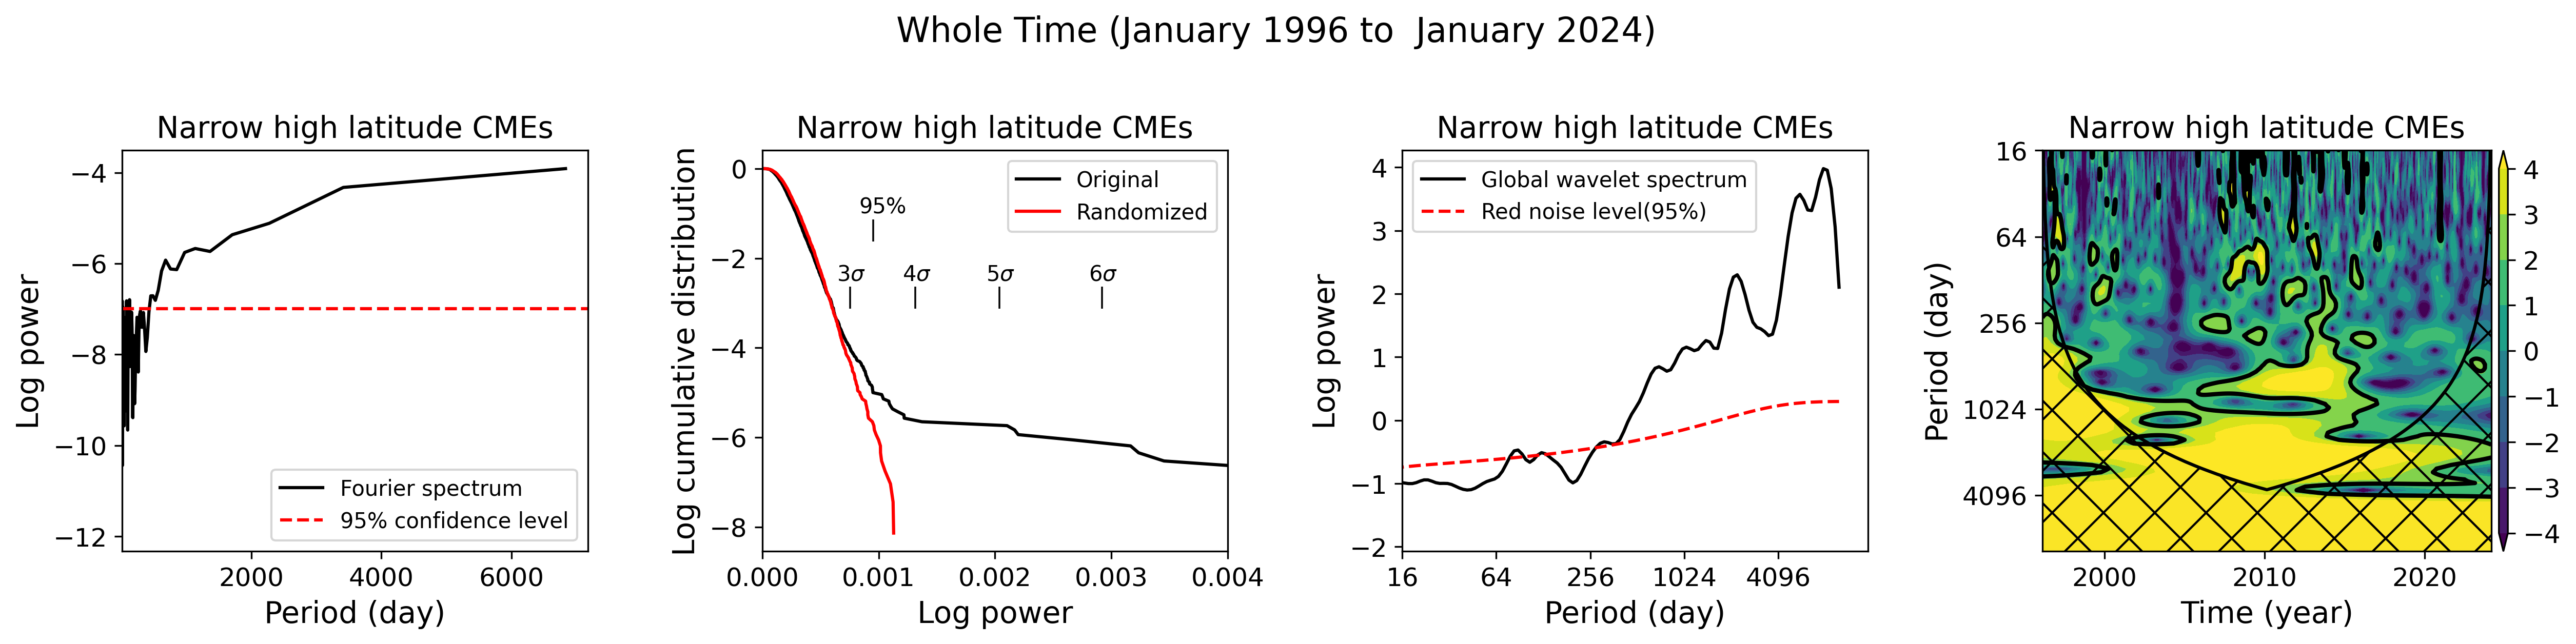

In [28]:
# 绘制图片(傅立叶功率谱、累积分布图)
import pandas as pd
figprops = dict(figsize=(20,22), dpi=300)
fig = pyplot.figure(**figprops)   
gs = GridSpec(10,8, wspace=1.2, hspace=1.2) 
# pyplot.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95,
#                             wspace=0, hspace=0)
fig.suptitle('Whole Time (January 1996 to  January 2024)', y=0.92, fontsize=16)


# all
# 傅立叶功率图
df = pd.read_csv("fillNarrow CME High.csv",header= None)
first_two_columns = df.iloc[:, :2].values
l1,Sl1,power_95,data_sorted,pro,data1_sorted,pro1,Sigma_square,sign = Fourier_Power_Spectrum(dat = first_two_columns[:,1],t = first_two_columns[:,0],sign = "Narrow high latitude")
ax01 = pyplot.subplot(gs[0:2, 0:2])
ax01.plot(l1,numpy.log(Sl1),'black',label='Fourier spectrum')
pyplot.axhline(y=numpy.log(power_95), c="r", ls="--",label='95% confidence level')
# pyplot.text(36,0.0075,'1.2 Mo')
# pyplot.text(89,0.006,'3 Mo')
# ax01.annotate('1.2 Mo', xy=(36, -6.3), xytext=(90, -2.1), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax01.annotate('2.9 Mo', xy=(89, -6.5), xytext=(690, -2.7), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax01.annotate('4.9 Mo', xy=(148, -6.4), xytext=(870, -4), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax01.annotate('6 Mo', xy=(182, -5.5), xytext=(2550, -3.7), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax01.annotate('9 Mo', xy=(275, -6.5), xytext=(1500, -6.5), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax01.annotate('1 Yr', xy=(367, -6), xytext=(2700, -6.1), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax01.annotate('1.2 Yr', xy=(445, -5.6), xytext=(2000, -5.6), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
# ax01.annotate('2.4 Yr', xy=(894, -5), xytext=(2100, -5), 
#             xycoords="data",
#             arrowprops=dict(arrowstyle="->"))
ax01.set_xlabel('Period (day)',fontsize=14)
ax01.set_ylabel('Log power',fontsize=14)
#     pyplot.ylim(0,0.005)
pyplot.xlim(16,)
# pyplot.ylim(0,0.16)
pyplot.legend(loc='lower right', fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)

# 累积分布图
ax02= pyplot.subplot(gs[0:2,2:4])
ax02.plot(data1_sorted,pro1,color='black',label='Original')
ax02.plot(data_sorted,pro,color='red',label='Randomized')
# 标记标准差
# print('3sigma=',9*Sigma_square)
pyplot.text(power_95-0.00009,-1,'95%')
pyplot.text(power_95,-1.5,"|")
    
pyplot.text(8*Sigma_square,-2.5,"3"r"$\sigma$")
pyplot.text(9*Sigma_square,-3,"|")

pyplot.text(15*Sigma_square,-2.5,"4"r"$\sigma$")
pyplot.text(16*Sigma_square,-3,"|")

pyplot.text(24*Sigma_square,-2.5,"5"r"$\sigma$")
pyplot.text(25*Sigma_square,-3,"|")

pyplot.text(35*Sigma_square,-2.5,"6"r"$\sigma$")
pyplot.text(36*Sigma_square,-3,"|")
ax02.set_xlabel('Log power',fontsize=14)
ax02.set_ylabel('Log cumulative distribution',fontsize=14)
pyplot.xlim(0,0.004)
# pyplot.xlim(0,0.16)
pyplot.legend(loc='upper right',fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)
#pyplot.savefig('Fouier359low50.png', format='png')  # 保存为PNG格式




# narrow
# 全局小波功率图
df = pd.read_csv("fillNarrow CME High.csv",header= None)
first_two_columns = df.iloc[:, :2].values
period,glbl_signif,var,glbl_power,t0array,power,sig95,coi,sign = Wavelet_Power_Spectrum(dat = pd.to_numeric(first_two_columns[:,1]),t = first_two_columns[:,0],sign = "Narrow high latitude")
ex05 = pyplot.subplot(gs[0:2,4:6])
ex05.plot(period, numpy.log(var * glbl_power), 'k-', label = 'Global wavelet spectrum')
ex05.plot(period, numpy.log(glbl_signif), 'r--', label = 'Red noise level(95%)')

# 格式化的X轴比例  
ex05.set_xscale('log', base=2, subs=None)
zhou = pyplot.gca().xaxis
zhou.set_major_formatter(ticker.ScalarFormatter())
ex05.ticklabel_format(axis='x', style='plain')
ex05.set_ylabel('Log power',fontsize=14)
ex05.set_xlabel('Period (day)',fontsize=14)
#     pyplot.ylim(16,6000)
pyplot.xlim(16,)
# ex05.annotate('7.4 Mo', xy=(224,5.22), xytext=(133,200), 
#             arrowprops=dict(arrowstyle="->"))
# ex05.annotate('1.9 Yr', xy=(707,24.58), xytext=(233,300), 
#             arrowprops=dict(arrowstyle="->"))
# ex05.annotate('2.5 Yr', xy=(913,27.61), xytext=(533,200), 
#             arrowprops=dict(arrowstyle="->"))
# ex05.annotate('4.1 Yr', xy=(1497,89.9), xytext=(900,300), 
#             arrowprops=dict(arrowstyle="->"))
# ex05.annotate('7.3 Yr', xy=(2669,143.2), xytext=(1517,360.8), 
#             arrowprops=dict(arrowstyle="->"))
pyplot.legend(loc='upper left',fontsize=10)
pyplot.tick_params(labelsize=12)
pyplot.title(sign+' CMEs',fontsize=14)
    
      
# 局部小波功率图
bx05 = pyplot.subplot(gs[0:2,6:8])
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
im = bx05.contourf(t0array, period, numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t0array.min(), t0array.max(), 0, max(period)]
bx05.contour(t0array, period, sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
pyplot.fill_between(t0array, coi * 0 + period[-1], coi, alpha= 0.01, hatch='x')
pyplot.plot(t0array, coi, 'k')   # 锥型线的轮廓
bx05.set_yscale('log', base=2, subs=None)  

# 格式化的Y轴比例  
zhou = pyplot.gca().yaxis
zhou.set_major_formatter(ticker.ScalarFormatter())
bx05.ticklabel_format(axis='y', style='plain')  

bx05.set_ylabel('Period (day)',fontsize=14)
bx05.set_xlabel("Time (year)",fontsize=14)
#     pyplot.xlim(1995.9, 2021.9)
#     pyplot.xlim(1996.07, 2021.76)
#     pyplot.ylim(16,6000)
pyplot.ylim(16,)
bx05.invert_yaxis()
pyplot.title(sign+' CMEs',fontsize=14)
divider = make_axes_locatable(bx05)
pyplot.tick_params(labelsize=12)
cax = divider.append_axes("right", size="2%", pad=0.05)
#     cbar = pyplot.colorbar(im)
pyplot.colorbar(im, cax=cax)
pyplot.tick_params(labelsize=12)




# pyplot.savefig('Figure3.png', bbox_inches = 'tight',transparent=True,dpi=120,pad_inches = 0.1)

pyplot.show()



